In [12]:
import numpy as np
import pandas as pd
import joblib
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [13]:
file_url = 'https://raw.githubusercontent.com/nazmulhasan202/\
UA-ECE-523-Sp2018/master/data/mushroom.csv'
df = pd.read_csv(file_url, header = None)
df = df.sample(frac=1)
df = df[(df[df.shape[1]-1]==0) | (df[df.shape[1]-1]==1)]
df[df.shape[1]-1].replace({0:-1}, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2965,-0.545748,0.217879,0.777065,-1.185840,0.610844,0.162886,-0.438837,-0.668997,0.978505,0.873457,...,0.660755,0.724578,-1.090590,0.142028,-0.256116,0.948023,-0.729846,0.284312,1.098090,-1
3890,0.563776,0.217879,-0.384244,0.843178,-0.397384,0.162886,-0.438837,-0.668997,-0.218239,-1.144740,...,-0.488212,-2.074060,-2.001910,0.142028,-0.256116,-0.162057,-0.021958,1.082980,-1.272800,1
7639,1.673300,0.217879,0.777065,0.843178,1.619070,0.162886,-0.438837,1.494590,-0.816611,0.873457,...,-0.488212,-0.208302,0.732067,0.142028,-0.256116,-1.272140,1.393820,0.284312,1.098090,1
2558,-0.545748,0.217879,-0.384244,-1.185840,0.610844,0.162886,-0.438837,-0.668997,-1.115800,0.873457,...,0.660755,-0.208302,0.732067,0.142028,-0.256116,0.948023,-0.729846,0.284312,1.098090,-1
4562,-0.545748,0.217879,1.357720,0.843178,-0.397384,0.162886,-0.438837,-0.668997,-0.517425,-1.144740,...,-0.488212,-2.540500,-0.179259,0.142028,-0.256116,-0.162057,-0.021958,1.082980,-0.087357,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,0.563776,-1.477570,-0.384244,-1.185840,0.610844,0.162886,-0.438837,-0.668997,-1.115800,0.873457,...,0.660755,0.724578,-1.090590,0.142028,-0.256116,0.948023,-1.083790,1.082980,1.098090,-1
5253,0.563776,0.217879,1.357720,0.843178,-0.397384,0.162886,-0.438837,-0.668997,-0.218239,-1.144740,...,-0.488212,-2.074060,-2.457570,0.142028,-0.256116,-0.162057,-0.021958,0.284312,-0.087357,1
7130,1.673300,0.217879,0.777065,0.843178,-0.901498,0.162886,-0.438837,1.494590,-0.816611,0.873457,...,0.660755,-0.208302,0.732067,0.142028,-0.256116,-1.272140,1.393820,0.284312,1.098090,1
7340,-0.545748,1.065600,-1.255230,0.843178,1.619070,0.162886,-0.438837,1.494590,-0.816611,0.873457,...,-0.488212,-0.208302,-0.179259,0.142028,-0.256116,-1.272140,1.393820,0.284312,1.098090,1


In [14]:
X = df.drop(columns=(df.shape[1]-1)).to_numpy()
y = df[(df.shape[1]-1)].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# My Class for Adaboost Classifier

In [15]:
class NH_Adaboost:

  from sklearn import tree

  def __init__(self, n_estimators=20,
               classifier=tree.DecisionTreeClassifier(max_depth=1,
                                                      criterion="entropy")):
    
    self.classifier = classifier
    self.n_estimators = n_estimators
    self.alpha = None
    self.H = None

  def fit(self, X_model, y_model):
    D = np.ones(len(y_model))/len(y_model)
    alpha = []
    H = []
    for t in range(self.n_estimators):

      h_t = self.classifier.fit(X_model, y_model, sample_weight = D)

      filename = 'h_'+str(t+1)+'.sav'
      joblib.dump(h_t, filename)
      loaded_model = joblib.load(filename)
      H.append(loaded_model)

      y_pred = h_t.predict(X_model)
      error_index = y_pred != y_model
      e_t = np.dot(D, error_index)
      alpha_t = 0.5*np.log((1-e_t)/e_t)
      alpha.append(alpha_t)
      z_t = 2*np.sqrt((1-e_t)*e_t)
      D_new = (D/z_t)*np.exp(-alpha_t*y_model*y_pred)
      D = D_new
    self.alpha = alpha
    self.H = H  
    return self.H

  def predict(self, X_model, ensemble_length = None): 
    if ensemble_length == None:
      ensemble_length = self.n_estimators
    H_pred = []
    for i in range(len(X_model.T[0])):
      sum = 0
      for j in range(ensemble_length):
        sum += self.alpha[j]*self.H[j].predict([X_model[i]])
      H_pred.append(np.sign(sum))
    H_pred = np.array(H_pred).squeeze()
    H_pred = H_pred.astype(int)
    return H_pred

# Performance comparison of **My Adaboost Classifier**, **SkLearn's Adaboost Classifier**, and **Decision Stump**

In [16]:
max_number_of_base_learners = 20
MyAdaboostAccuracy = []
SkAdaboostAccuracy = []
StumpAccuracy = []
base_classifier = tree.DecisionTreeClassifier(max_depth=1)
my_model = NH_Adaboost(classifier = base_classifier, 
                       n_estimators=max_number_of_base_learners)
Ensemble = my_model.fit(X_train, y_train)
for i in range(max_number_of_base_learners):
  #Decision Stump
    stump = base_classifier.fit(X_train, y_train)
    y_pred = stump.predict(X_test)
    StumpAccuracy.append(metrics.accuracy_score(y_test,y_pred))
  #My Adaboost Classifier
    y_pred = my_model.predict(X_test, ensemble_length = i+1)
    MyAdaboostAccuracy.append(metrics.accuracy_score(y_test,y_pred))
  #Sklearn's Adaboost Classifier
    AdaModel = AdaBoostClassifier(base_estimator = base_classifier,
                                  n_estimators=i+1 )
    sk_model = AdaModel.fit(X_train, y_train)
    y_pred = sk_model.predict(X_test)
    y_pred = np.array([y_pred]).T
    SkAdaboostAccuracy.append(metrics.accuracy_score(y_test,y_pred))

MyAdaboostAccuracy = np.array(MyAdaboostAccuracy)
SkAdaboostAccuracy = np.array(SkAdaboostAccuracy)
StumpAccuracy = np.array(StumpAccuracy)

With a number of 14 base models My Adaboost Classifierhas highest accuracy of  99.07692307692308 %
With a number of 12 base models Sklearn's Adaboost Classifier has highest accuracy of 100.0 %
Decision Stump's accuracy is 85.04615384615384 %


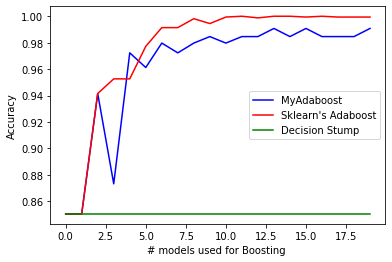

In [17]:
plt.plot(np.arange(len(MyAdaboostAccuracy)),MyAdaboostAccuracy,'-b')
plt.plot(np.arange(len(SkAdaboostAccuracy)),SkAdaboostAccuracy,'-r')
plt.plot(np.arange(len(StumpAccuracy)),StumpAccuracy,'-g')

plt.xlabel('# models used for Boosting ')
plt.ylabel('Accuracy')
plt.legend(('MyAdaboost','Sklearn\'s Adaboost','Decision Stump'))
Myk = np.argmax(MyAdaboostAccuracy) 
Sk = np.argmax(SkAdaboostAccuracy)
Dk = np.argmax(StumpAccuracy)
print('With a number of',Myk+1,
      'base models My Adaboost Classifierhas highest accuracy of ',
      MyAdaboostAccuracy[Myk]*100,'%')    
print('With a number of',Sk+1,
      'base models Sklearn\'s Adaboost Classifier has highest accuracy of',
      SkAdaboostAccuracy[Sk]*100,'%')
print('Decision Stump\'s accuracy is',
      StumpAccuracy[Dk]*100,'%')